# (experimental) Badge Visualizations 


## Badge status 

```{warning}
this is not guaranteed to stay up to date with current, but the listed date is accurate. 
You can see the code that generates the figure behind the "click to show" button.  It is  Python code that you should be able to run anywhere with the required libraries installed. 
```

Text(0.5, 1.0, 'Badge Status as of 2023-03-02')

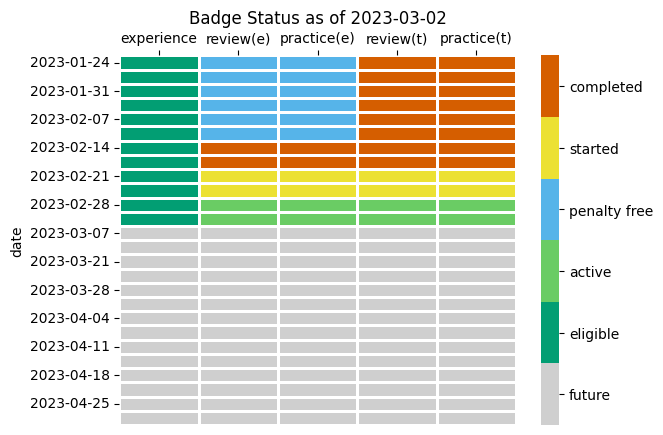

In [1]:
%matplotlib inline
import os
from datetime import date,timedelta
import calendar
import pandas as pd
import numpy as np
import seaborn as sns
from myst_nb import glue
# style note: when I wrote this code, it was not all one cell. I merged the cells
# for display on the course website, since Python is not the main outcome of this course

# semester settings
first_day = date(2023,1,24)
last_day = date(2023,5,1)
meeting_days =[1,3] # datetime has 0=Monday
spring_break = (date(2023,3,11),date(2023,3,19))
penalty_free_end = date(2023, 2, 9)


# enumerate weeks
weeks = int((last_day-first_day).days/7+1)

# create differences
mtg_delta = timedelta(meeting_days[1]-meeting_days[0])
week_delta = timedelta(7)

# function to check if a date is during spring break
during_sb = lambda d: spring_break[0]<d<spring_break[1]

# generate the number of weeks worth of dates
possible = [(first_day+week_delta*w, first_day+mtg_delta+week_delta*w) for w in range(weeks)]
# rm spring break dates
weekly_meetings = [[c1,c2] for c1,c2 in possible if not(during_sb(c1))]
#unpack into single list
meetings = [m for w in weekly_meetings for m in w]


# build a table for the dates
badge_types = ['experience', 'review', 'practice']
target_cols = ['review_target','practice_target']
df_cols = badge_types + target_cols
badge_target_df = pd.DataFrame(index=meetings, data=[['future']*len(df_cols)]*len(meetings),
                                columns=df_cols).reset_index().rename(
                                   columns={'index': 'date'})
# set relative dates
today = date.today()
start_deadline = date.today() - timedelta(7)
complete_deadline = date.today() - timedelta(14)

# mark eligible experience badges
badge_target_df['experience'][badge_target_df['date'] <= today] = 'eligible'
# mark targets, cascading from most recent to oldest to not have to check < and >
badge_target_df['review_target'][badge_target_df['date'] <= today] = 'active'
badge_target_df['practice_target'][badge_target_df['date'] <= today] = 'active'
badge_target_df['review_target'][badge_target_df['date']
                          <= start_deadline] = 'started'
badge_target_df['practice_target'][badge_target_df['date']
                            <= start_deadline] = 'started'
badge_target_df['review_target'][badge_target_df['date']
                          <= complete_deadline] = 'completed'
badge_target_df['practice_target'][badge_target_df['date']
                            <= complete_deadline] = 'completed'
# mark enforced deadlines
badge_target_df['review'][badge_target_df['date'] <= today] = 'active'
badge_target_df['practice'][badge_target_df['date'] <= today] = 'active'
badge_target_df['review'][badge_target_df['date']
                          <= start_deadline] = 'started'
badge_target_df['practice'][badge_target_df['date']
                            <= start_deadline] = 'started'
badge_target_df['review'][badge_target_df['date']
                          <= complete_deadline] = 'completed'
badge_target_df['practice'][badge_target_df['date']
                            <= complete_deadline] = 'completed'
badge_target_df['review'][badge_target_df['date']
                          <= penalty_free_end] = 'penalty free'
badge_target_df['practice'][badge_target_df['date']
                          <= penalty_free_end] = 'penalty free'

# convert to numbers and set dates as index for heatmap compatibility
status_numbers_hm = {status:i+1 for i,status in enumerate(['future','eligible','active','penalty free','started','completed'])}
badge_target_df_hm = badge_target_df.replace(status_numbers_hm).set_index('date')

# set column names to shorter ones to fit better
badge_target_df_hm = badge_target_df_hm.rename(columns={'review':'review(e)','practice':'practice(e)',
                                                       'review_target':'review(t)','practice_target':'practice(t)',})
# build a custom color bar 
n_statuses = len(status_numbers_hm.keys())
manual_palette = [sns.color_palette("pastel", 10)[7],
                 sns.color_palette("colorblind", 10)[2],
                 sns.color_palette("muted", 10)[2],
                 sns.color_palette("colorblind", 10)[9],
                 sns.color_palette("colorblind", 10)[8],
                 sns.color_palette("colorblind", 10)[3]]
# generate the figure, with the colorbar and spacing
ax = sns.heatmap(badge_target_df_hm,cmap=manual_palette,linewidths=1)
# mote titles from bottom tot op
ax.xaxis.tick_top()
# pull the colorbar object for handling
colorbar = ax.collections[0].colorbar 
# fix the location fo the labels on the colorbar
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n_statuses * (0.5 + i) for i in range(n_statuses)])
colorbar.set_ticklabels(list(status_numbers_hm.keys()))
# add a title
today_string = today.isoformat()
glue('today',today_string,display=False)
glue('today_notdisplayed',"not today",display=False)
ax.set_title('Badge Status as of '+ today_string); 

The (e) columns are what will be enforced, the (t) columns is ideal, see the [deadlines section of the syllabus for more on the statuses](rp-status) for more detail. 

The following table shows, as of  {glue:}`today`, the number of badges with each status.

In [2]:
status_list_summary = ['eligible', 'penalty free', 'active', 'started', 'completed']
badge_count_df = badge_target_df[badge_target_df['date']<today].apply(pd.value_counts).loc[status_list_summary].drop(
                    columns='date').fillna(' ')

glue('exp_ontrack',int(badge_count_df.loc['eligible','experience']),display=False)
glue('exp_min',int(badge_count_df.loc['eligible','experience']-3),display=False)
glue('rp_completed',int(badge_count_df.loc['completed','review_target']),display=False)
glue('rp_started',int(badge_count_df.loc['started','review_target']),display=False)
badge_count_df

,experience,review,practice,review_target,practice_target
eligible,11.0,,,,
penalty free,,6.0,6.0,,
active,,1.0,1.0,1.0,1.0
started,,2.0,2.0,2.0,2.0
completed,,2.0,2.0,8.0,8.0


````{margin}
```{note}
This date is formatted like this because it comes from the code
```
```{important}
Remember, there will be 26 badge opportunities, but do not need all of them.  See the [](badgecounts) section of the syllabus for how they map into letter grades
```
````


This means that, as of {glue:}`today` you are fully caught up if you have:
-  {glue:}`exp_ontrack` experience badges submitted. 
-  {glue:}`rp_completed` total review and practice badges completed.
-  {glue:}`rp_started` additional review and/or practice badges started and in progress. 


Notes: 
-  If you do not have at least {glue:}`exp_min` experience badges earned, you should visit office hours to get caught up. 
-  There are are 6 review and practice badges that are from the penalty free zone, so they never expire. 
-  Most of your experience and completed badges should be earned, but there is no deadline to fix issues with them. 


## Prepare work and Experience Badges Process

This is for a single example with specific dates, but it is similar for all future dates

The columns (and purple boxes) correspond to branches in your KWL repo and the yellow boxes are the things that you have to do. The "critical" box is what you have to wait for us on. The arrows represent PRs (or a local merge for the first one)


```{mermaid}
sequenceDiagram
    participant P as prepare Feb 21
    participant E as experience Feb 23
    participant M as main 
    note over P: complete prepare work<br/> between feb 21 and 23
    note over E: run experience badge workflow <br/> at the end of class feb 23
    P ->> E: local merge or PR you that <br/> does not need approval
    note over E: fill in experience reflection 
    critical Badge review by instructor or TA
        E ->> M: Experience badge PR
    option if edits requested
        note over E: make requested edits
    option when approved 
        note over M: merge badge PR
    end
```

In the end the commit sequence for this will look like the following:

```{mermaid}
gitGraph
   commit
   commit
   checkout main
   branch prepare-2023-02-21
   checkout prepare-2023-02-21
   commit id: "gitunderstanding.md"
   branch experience-2023-02-23
   checkout experience-2023-02-23
   commit id: "initexp"
   merge prepare-2023-02-21
   commit id: "fillinexp"
   commit id: "revisions" tag:"approved"
   checkout main
   merge experience-2023-02-23
```

Where the "approved" tag represents and approving reivew on the PR. 


## Review and Practice Badge 


Legend:
```{mermaid}
flowchart TD
    badgestatus[[Badge Status]]
    passive[/ something that has to occur<br/> not done by student /]      
    student[Something for you to do]

    style badgestatus fill:#2cf

    decisionnode{Decision/if}
      sta[action a]
      stb[action b]
      decisionnode --> |condition a|sta
      decisionnode --> |condition b|stb
    subgraph phase[Phase]
      st[step in phase]
    end
```

This is the general process for review and practice badges 

```{mermaid}
flowchart TD
%%    subgraph work[Steps to complete]
    subgraph posting[Dr Brown will post the Badge]
      direction TB
      write[/Dr Brown finalizes tasks after class/]
      post[/Dr. Brown pushes to github/]
      link[/notes are posted  with badge steps/]
      posted[[Posted: on badge date]]
      write -->post
      post -->link
      post --o posted
    end
    subgraph planning[Plan the badge]
      direction TB
      create[/Dr Brown runs your workflow/]
      decide{Do you need this badge?}
      close[close the issue]
      branch[create branch]
      planned[[Planned: on badge date]]
      create -->decide
      decide -->|no| close
      decide -->|yes| branch
    create --o planned
    end
    subgraph work[Work on the badge]
      direction TB
      start[do one task]
      commit[commit work to the branch]
      moretasks[complete the other tasks]
      ccommit[commit them to the branch]
      reqreview[request a review]
      started[[Started <br/> due within one week <br/> of posted date]]
      completed[[Completed <br/>due  within two weeks <br/> of posted date]]
      wait[/wait for feedback/]
      start --> commit
      commit -->moretasks
      commit --o started
      moretasks -->ccommit
      ccommit -->reqreview
      reqreview --> wait
      reqreview --o completed
    end
    subgraph review[Revise your completed badges]
      direction TB
      prreview[Read review feedback]
      approvedq{what type of review}
      merge[Merge the PR]
      edit[complete requested edits]
      earned[[Earned <br/> due by final grading]]
      discuss[reply to comments]
      prreview -->approvedq
      approvedq -->|changes requested|edit
      edit -->|last date to edit: May 1| prreview
      approvedq -->|comment|discuss
      discuss -->prreview
      approvedq -->|approved|merge
      merge --o earned
    end

    posting ==> planning
    planning ==> work
    work ==> review

%% styling 
style earned fill:#2cf
style completed fill:#2cf
style started fill:#2cf
style posted fill:#2cf
style planned fill:#2cf
```


## Explore Badges


```{mermaid}
flowchart TD
    subgraph proposal[Propose the Topic and Product]
      issue[create an issue]
      proposed[[Proposed]]
      reqproposalreview[Assign it to Dr. Brown]
      waitp[/wait for feedback/]
      proceedcheck{Did Dr. Brown apply a proceed label?}
      branch[start a branch]
      progress[[In Progress ]]
      iterate[reply to comments and revise]
      issue --> reqproposalreview
      reqproposalreview --> waitp
      reqproposalreview --> proposed
      waitp --> proceedcheck
      proceedcheck -->|no| iterate
      proceedcheck -->|yes| branch
      branch --> progress
      iterate -->waitp
    end
    subgraph work[Work on the badge]
      direction TB
      moretasks[complete the work]
      ccommit[commit work to the branch]
      reqreview[request a review]
      wait[/wait for feedback/]
      complete[[Complete]]
      moretasks -->ccommit
      ccommit -->reqreview
      reqreview --o complete
      reqreview --> wait
    end
    subgraph review[Revise your work]
      direction TB
      prreview[Read review feedback]
      approvedq{what type of review}
      revision[[In revision]]
      merge[Merge the PR]
      edit[complete requested edits]
      earned[[Earned <br/> due by final grading]]
      prreview -->approvedq
      approvedq -->|changes requested|edit
      edit --> prreview
      edit --o revision
      approvedq -->|approved| merge
      merge --o earned
    end

    proposal ==> work
    work ==> review

%% styling 
style proposed fill:#2cf
style progress fill:#2cf
style complete fill:#2cf
style revision fill:#2cf
style earned fill:#2cf

```



## Build Badges 


```{mermaid}
flowchart TD
    subgraph proposal[Propose the Topic and Product]
      issue[create an issue]
      proposed[[Proposed]]
      reqproposalreview[Assign it ]
      waitp[/wait for feedback/]
      proceedcheck{Did Dr. Brown apply a proceed label?}
      branch[start a branch]
      progress[[In Progress ]]
      iterate[reply to comments and revise]
      issue --> reqproposalreview
      reqproposalreview --> waitp
      reqproposalreview --> proposed
      waitp --> proceedcheck
      proceedcheck -->|no| iterate
      proceedcheck -->|yes| branch
      branch --> progress
      iterate -->waitp
    end
    subgraph work[Work on the badge]
      direction TB
      commit[commit work to the branch]
      moretasks[complete the work]
      draftpr[Open a draft PR and <br/> request a review]
      ccommit[incorporate feedback]
      reqreview[request a review]
      wait[/wait for feedback/]
      complete[[Complete]]
      commit -->moretasks
      commit -->draftpr
      draftpr -->ccommit
      moretasks -->reqreview
      ccommit -->reqreview
      reqreview --> complete
      reqreview --> wait
    end
    subgraph review[Revise your work]
      direction TB
      prreview[Read review feedback]
      approvedq{what type of review}
      revision[[In revision]]
      merge[Merge the PR]
      edit[complete requested edits]
      earned[[Earned <br/> due by final grading]]
      prreview -->approvedq
      approvedq -->|changes requested|edit
      edit --> prreview
      edit -->revision
      approvedq -->|approved| merge
      merge --o earned
    end

    proposal ==> work
    work ==> review

%% styling 
style proposed fill:#2cf
style progress fill:#2cf
style complete fill:#2cf
style revision fill:#2cf
style earned fill:#2cf

```